In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, plot_precision_recall_curve, average_precision_score
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Preprocessing of Metadata

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
16521,00004418_004.png,Atelectasis|Effusion,4,4418,55,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004418_004.png
71112,00017534_000.png,No Finding,0,17534,7,M,PA,2314,2157,0.143,0.143,NaN,/data/images_008/images/00017534_000.png
99573,00026361_000.png,No Finding,0,26361,46,M,PA,3044,2524,0.139,0.139,NaN,/data/images_011/images/00026361_000.png


### One-hot Encoding

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
print('Original Number of Features:', len(all_xray_df.columns))
one_hot = all_xray_df['Finding Labels'].str.get_dummies('|')
all_xray_df = all_xray_df.drop('Finding Labels', axis=1)
all_xray_df = all_xray_df.join(one_hot)
all_xray_df.head(10)

Original Number of Features: 13


,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0
5,00000003_001.png,1,3,74,F,PA,2500,2048,0.168,0.168,...,0,0,1,0,0,0,0,0,0,0
6,00000003_002.png,2,3,75,F,PA,2048,2500,0.168,0.168,...,0,0,1,0,0,0,0,0,0,0
7,00000003_003.png,3,3,76,F,PA,2698,2991,0.143,0.143,...,0,0,1,1,0,0,0,0,0,0
8,00000003_004.png,4,3,77,F,PA,2500,2048,0.168,0.168,...,0,0,1,0,0,0,0,0,0,0
9,00000003_005.png,5,3,78,F,PA,2686,2991,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0


### Casting the Pneumonia column from int to string

In [4]:
all_xray_df['Pneumonia'] = all_xray_df['Pneumonia'].astype(str)

In [5]:
print(all_xray_df['Pneumonia'].dtype)

object


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
lst = []
for idx in range(len(all_xray_df)):
    if all_xray_df['Pneumonia'][idx] == '1': lst.append('1')
    else: lst.append('0')
all_xray_df.loc[:,'pneumonia_class'] = lst
print(np.sum(all_xray_df['pneumonia_class']))
all_xray_df.head()

0000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000001001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000010000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000100001000000000000000000000000000000000000110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,1,0,0,0,0,0,0,0,0


## Create training and testing data

In [7]:
train_data, val_data = train_test_split(all_xray_df, test_size=0.30)
train_data_neg = train_data[train_data['pneumonia_class'] == '0']
train_data_pos = train_data[train_data['pneumonia_class'] == '1']
bottleneck_size = min(len(train_data_neg), len(train_data_pos))
print(bottleneck_size)

1031


In [8]:
def create_splits():
    all_xray_df_neg = all_xray_df[all_xray_df['pneumonia_class'] == '0']
    all_xray_df_pos = all_xray_df[all_xray_df['pneumonia_class'] == '1']
    bottleneck_size = min(len(all_xray_df_neg), len(all_xray_df_pos))
    all_xray_df_neg_sample = all_xray_df_neg.sample(n=bottleneck_size)
    all_xray_df_pos_sample = all_xray_df_pos.sample(n=bottleneck_size)
    all_xray_df_sample = pd.concat([all_xray_df_neg_sample, all_xray_df_pos_sample])
    
    train_data, val_data = train_test_split(all_xray_df_sample, test_size=0.30)
    
    return train_data, val_data

In [9]:
train_data, val_data = create_splits()
train_data_neg = train_data[train_data['pneumonia_class'] == '0']
train_data_pos = train_data[train_data['pneumonia_class'] == '1']
print('Negative Class Values:', len(train_data_neg))
print('Positive Class Values:', len(train_data_pos))

Negative Class Values: 1001
Positive Class Values: 1002


In [10]:
train_split_proportion = len(train_data) / (len(train_data) + len(val_data))
val_split_proportion = 1 - train_split_proportion
print('Train Pct:', train_split_proportion, ', Val Pct:', val_split_proportion)

Train Pct: 0.6998602375960866 , Val Pct: 0.3001397624039134


# Model-building and Training

In [11]:
def my_image_augmentation():
    
    ## recommendation here is to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    my_idg = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip = False,
                             vertical_flip = True,
                             width_shift_range = 0.15,
                             height_shift_range = 0.10,
                             rotation_range = 45,
                             shear_range = 0.2,
                             zoom_range = 0.25)
    return my_idg


def make_train_gen(train_df):
    
    train_gen = my_image_augmentation().flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = (224,224),
                                         batch_size = 32)
    return train_gen


def make_val_gen(val_data):
    
    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'binary',
                                              target_size = (224,224),
                                              batch_size = 32)
    return val_gen

In [12]:
val_gen = make_val_gen(val_data)
valX, valY = val_gen.next()

Found 859 validated image filenames belonging to 2 classes.


Found 2003 validated image filenames belonging to 2 classes.


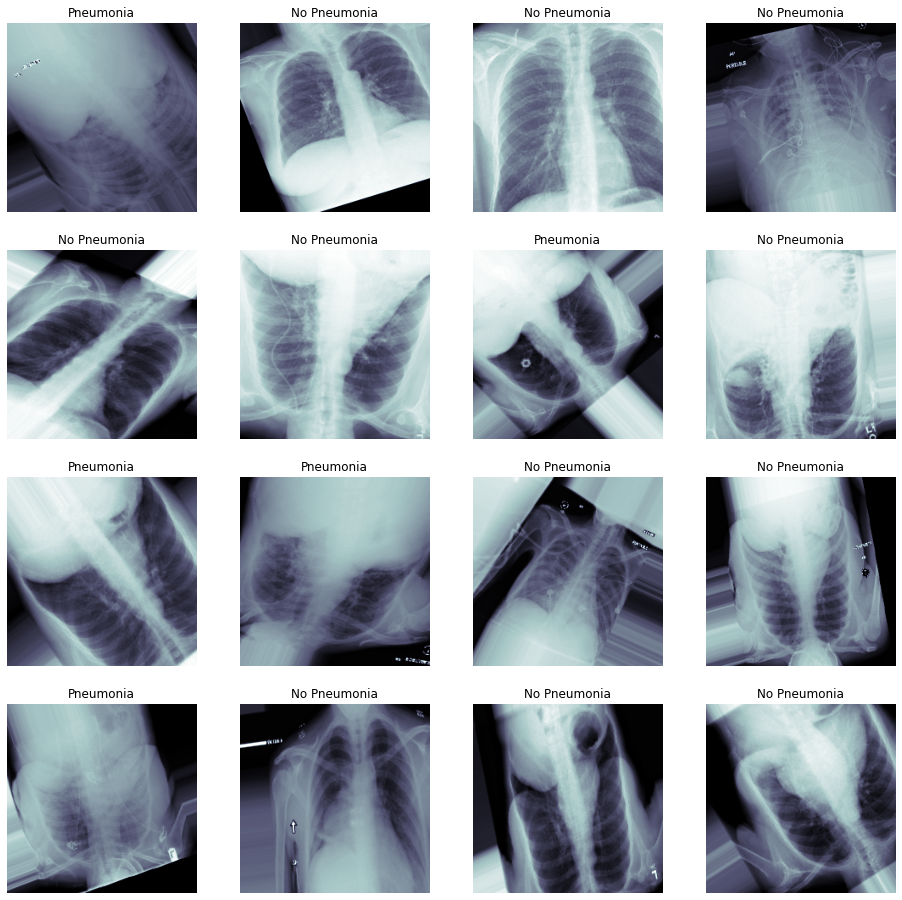

In [13]:
train_gen = make_train_gen(train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Constructing the Model

In [14]:
def load_pretrained_model(lay_of_interest):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    layers = vgg_model.layers[0:16]
    for lay in layers:
        lay.trainable = False
    
    return vgg_model

In [15]:
def build_my_model():
    my_model = Sequential()
    my_model.add(load_pretrained_model('block5_pool'))
    my_model.add(Flatten())
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

In [16]:
my_model = build_my_model()
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [18]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Training the Model

In [19]:
history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 7, 
                                 callbacks = callbacks_list)

Epoch 1/7
63/63 [==============================] - 55s 880ms/step - loss: 0.7998 - accuracy: 0.4968 - val_loss: 0.7220 - val_accuracy: 0.4375

Epoch 00001: val_loss improved from inf to 0.72203, saving model to xray_class_my_model.best.hdf5
Epoch 2/7
63/63 [==============================] - 52s 823ms/step - loss: 0.6969 - accuracy: 0.4933 - val_loss: 0.6911 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 0.72203 to 0.69107, saving model to xray_class_my_model.best.hdf5
Epoch 3/7
63/63 [==============================] - 52s 826ms/step - loss: 0.6980 - accuracy: 0.4898 - val_loss: 0.6952 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.69107
Epoch 4/7
63/63 [==============================] - 51s 812ms/step - loss: 0.6939 - accuracy: 0.5312 - val_loss: 0.7309 - val_accuracy: 0.3750

Epoch 00004: val_loss did not improve from 0.69107
Epoch 5/7
63/63 [==============================] - 51s 813ms/step - loss: 0.6923 - accuracy: 0.5197 - val_loss: 0.6921 - val_a

##### After training for some time, look at the performance of your model by plotting some performance statistics:

In [20]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
true_Y = valY

32/32 [==============================] - 0s 11ms/step


In [21]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc_val = auc(fpr, tpr)
    return auc_val

def plot_roc(t_y, p_y):
    plt.figure()
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

def compute_f1_score(precision, recall):
    f1 = 2 * (recall * precision) / (recall + precision)
    return f1

def plot_history(history):
    plt.plot(history.history['val_accuracy'], color='blue')
    plt.plot(history.history['accuracy'], color='orange')
    plt.xlabel('Time')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Score vs. Time')
    return history

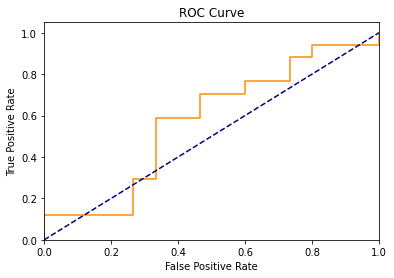

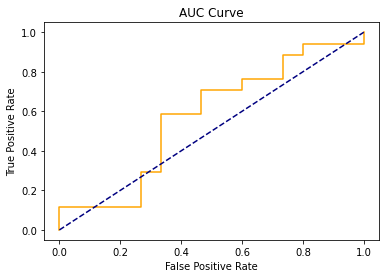

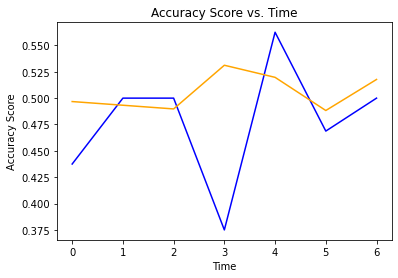

In [22]:
plot_roc(true_Y, pred_Y)
plot_history(history)

Once you feel you are done training, you will need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.).

### Precision-Recall Curve

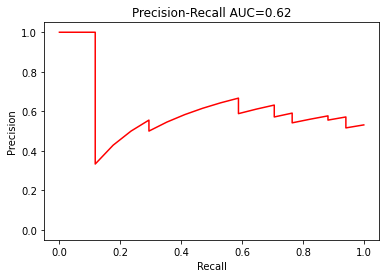

In [23]:
precision, recall, thresholds = precision_recall_curve(true_Y, pred_Y, pos_label=1)
plt.plot(recall, precision, color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.title('Precision-Recall AUC={0:0.2f}'.format(average_precision_score(valY, pred_Y)))
plt.show()

### Precision and Recall vs. Threshold

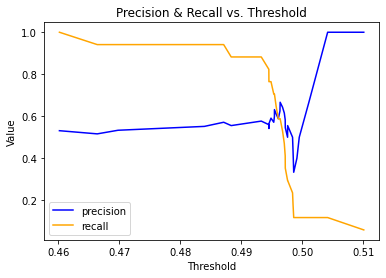

In [24]:
plt.plot(thresholds, precision[:-1], color='blue', label='precision')
plt.plot(thresholds, recall[:-1], color='orange', label='recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision & Recall vs. Threshold')
plt.legend()
plt.show()

### F1 Score vs. Threshold

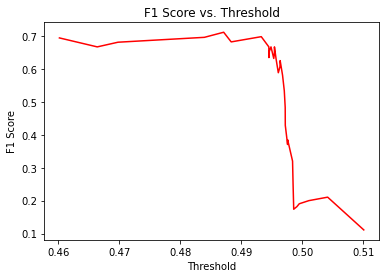

In [25]:
plt.plot(thresholds, 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1]), color='red')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

The optimal threshold that maximizes the F1 Score is approximately 0.485. We will use this threshold value in the code below.

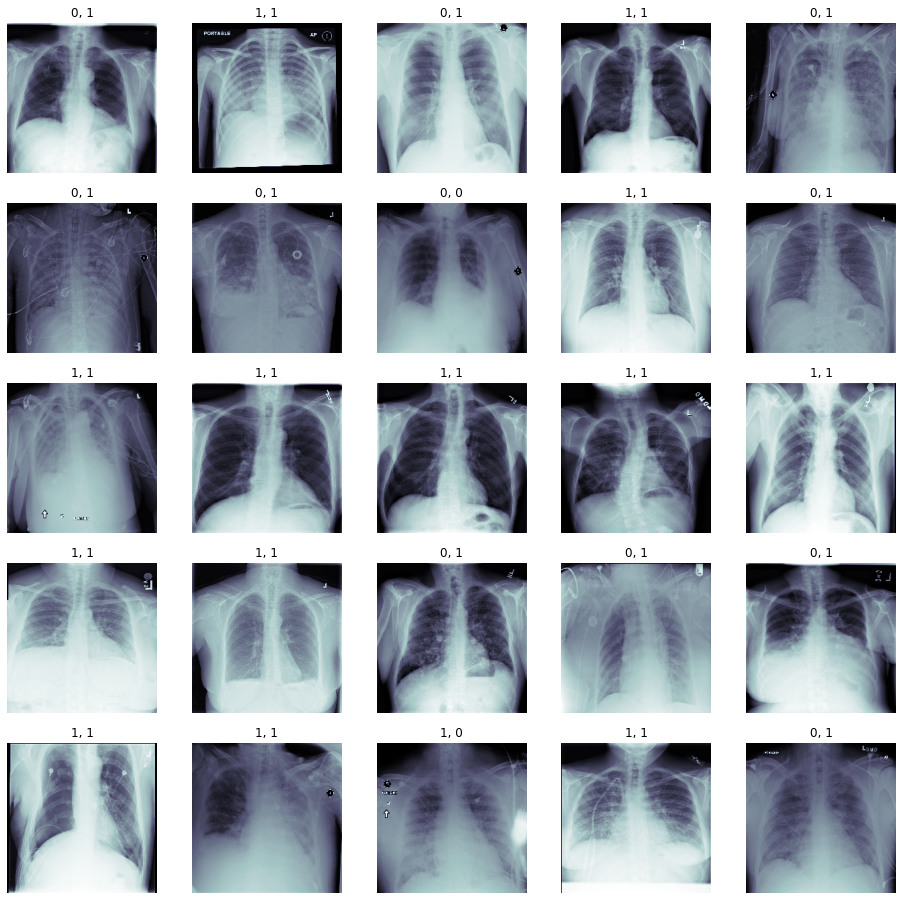

In [26]:
fig, m_axs = plt.subplots(5, 5, figsize = (16,16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1:
         if pred_Y[i] > 0.485:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.485:
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

### Saving Model to JSON File

In [27]:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)